In [1]:
from IPython.display import Image

## Word2Vec의 대안으로 사용되는 글로브와 패스트텍스트에 대해서 알아보자.

### 1. GloVE

카운트 기반과, 예측 기반을 모두 사용하는 방법론이다.
기존의 카운트 기반 LSA와 예측 기반의 Word2Vec의 단점을 지적하며 보완 목적으로 나왔다.

#### 1) 기존 방법론에 대한 비판

LSA는 각 단어의 빈도를 카운트한 행렬이라는 전체적인 통계 정보를 입력으로 받아 차원을 축소(Truncated SVD)하여 잠재된 의미를 끌어내는 방법론이다.  
카운트 기반으로 코퍼스의 전체적인 통계 정보를 고려하기는 하지만, 왕:남자 = 여왕:?(answer is 여자)와 같은 단어 의미의 유추 작업(Analogy task)에는 성능이 떨어진다.  

반면 Word2Vec은 실제값과 예측값에 대한 오차를 손실 함수를 통해 줄여나가며 학습하는 예측 기반의 방법론이다. 임베팅 벡터가 윈도우 크기 내에서만 주변 단어를 고려하기 때문에, 코퍼스의 전체적인 통계 정보를 반영하지 못한다.  

GloVE는 위 두 가지 방법론을 모두 사용한다.

#### 2) 윈도우 기반 동시 등장 행렬(Window based Co-occurence Matrix)

행과 열을 전체 단어 집합의 단어들로 구성한다.  
i 단어의 Window Size 내에서 k 단어가 등장한 횟수를 (i,k)에 기재한 행렬이다.

예시를 보자.  
I like deep learning  
I like NLP  
I enjoy flying  

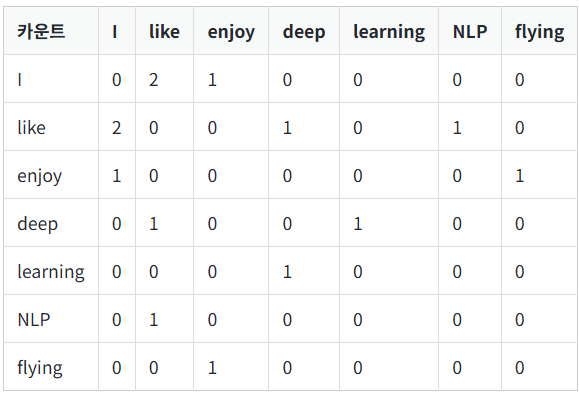

In [2]:
Image("./scr/12-05 window based Co-occurence Matrix.png")

Transpose해도 동일한 행렬이라는 특징이 있다.

#### 3) 동시 등장 확률(Co-occurrence Probability)

동시 등장 확률 $P(k|i)$는 동시 등장 행렬로부터 특정 단어 i의 전체 등장 횟수를 카운트하고,  
특정 단어 i가 등장했을 때 어떤 단어 k가 등장한 횟수를 카운트하여 계산한 조건부 확률이다.

즉, (i행의 k열의 값)/(i행의 모든 값을 더한 합)이다.

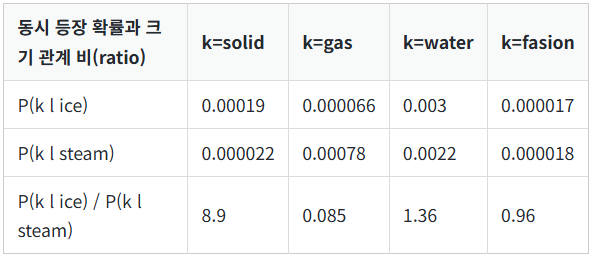

In [2]:
Image("./scr/12-05 Co-occurence Probability.png")

위 표는 GloVe의 제안 논문에서 가져온 예시 표이다.  
ice가 등장했을 때, steam이 등장한 확률 대비,  
ice가 등장했을 때, solid가 등장한 확률은 약 8.9배 더 크다.

#### 4) 손실 함수(Loss function)

용어를 정리하자.

- $X$ : 동시 등장 행렬(Co-occurrence Matrix)  
- $X_{ij}$ : 중심 단어 i가 등장했을 때 윈도우 내 주변 단어 j가 등장하는 횟수  
- $X_{i} : \sum_{j}{X_{ij}}$ : 동시 등장 행렬에서 i행의 값을 모두 더한 값  
- $P_{ik}$ : $P(k\ |\ i)$ = $\frac{X_{ik}}{X_{i}}$ : 중심 단어 i가 등장했을 때 윈도우 내 주변 단어 k가 등장할 확률    
Ex) P(solid l ice) = 단어 ice가 등장했을 때 단어 solid가 등장할 확률  
 
- $\frac{P_{ik}}{P_{jk}}$: $P_{ik}$를 $P_{jk}$로 나눠준 값  
Ex) P(solid l ice) / P(solid l steam) = 8.9  
- $w_{i}$ : 중심 단어 i의 임베딩 벡터  
- $\tilde{w_{k}}$ : 주변 단어 k의 임베딩 벡터  

GloVe의 아이디어를 한 줄로 요약하면  
'임베딩 된 중심 단어와 주변 단어 벡터의 내적이 전체 코퍼스에서의 동시 등장 확률이 되도록 만드는 것'이다. 즉, 이를 만족하도록 임베딩 벡터를 만드는 것이 목표이다. 이를 식으로 표현하면 다음과 같다.  

$dot\ product(w_{i}\ \tilde{w_{k}}) \approx\ P(k\ |\ i) = P_{ik}$

더 정확히는 아래와 같다.  
$dot\ product(w_{i}\ \tilde{w_{k}}) \approx\ log\ P(k\ |\ i) = log\ P_{ik}$

손실 함수를 처음부터 설계해보자.  
중요한 것은 단어 간의 관계를 잘 표현하는 함수여야 한다는 것이다.  
이를 위해 $P_{ik} / P_{jk}$를 식에 사용한다.  
Ex) P(solid l ice) / P(solid l steam) = 8.9  

연구진은  
$F(w_{i},\ w_{j},\ \tilde{w_{k}}) = \frac{P_{ik}}{P_{jk}}$  
초기 식으로 전개를 시작한다.  

함수 F는 두 단어 사이의 동시 등장 확률의 크기 관계 비율(ratio) 정보를 벡터 공간에 인코딩하는 것이 목적이다. 이를 위해 GloVe 연구진들은 $w_{i}$와, $w_{j}$라는 두 벡터의 차이를 함수 $F$의 입력으로 사용하는 것을 제안한다.  

$F(w_{i} -\ w_{j},\ \tilde{w_{k}}) = \frac{P_{ik}}{P_{jk}}$  

그런데 우변은 스칼라값이고 좌변은 벡터값이다.  
이를 성립시키기 위해서 함수 $F$의 입력에 내적을 수행한다.  
$F((w_{i} -\ w_{j})^{T} \tilde{w_{k}}) = \frac{P_{ik}}{P_{jk}}$  

정리하면, 선형 공간(Linear space)에서 단어의 의미 관계를 표현하기 위해 뺄셈과 내적을 택했다.  


여기서부터 이해가 안가서 나는 아래 사이트를 공부했다.  
https://nlp.stanford.edu/projects/glove/  

논문에서 말하길,  
'Since vector spaces are inherently linear structures, the most natural way to do this is with vector differences.'  

내가 궁금한 것은, 단어 간의 의미 관계를 표현하는데,  
어떻게 임베딩 벡터들끼리의 뺄셈으로 그 의미 관계가 encoding될 수 있냐는 것이다.  